# Make a Video of Defect Movement
Make a video where we color each defect based on its void

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colormaps
from rtdefects.io import load_file
from rtdefects.analysis import analyze_defects
from skimage.transform import resize
from skimage import measure
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

Configuration

In [2]:
run_path = Path('data/drift-corrected-625C/')

## Load in the Void Data
Load in the void tracks from a previous notebook and the overall summaries in each

In [3]:
void_tracks = pd.read_json(run_path / 'void_tracks.json')

In [4]:
frame_data = pd.read_json(run_path / 'frame_data.json')

In [5]:
frame_data

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,rtt,detect_time,frame
0,0.027991,63,"[8.6672448413, 21.1100412282, 43.2038096999, 9...",20.234154,"[[3.7627118644, 745.3389830508], [7.5828571429...",0.306487,2023-04-20 12:50:41.216,2023-04-24 14:38:43.062,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0000.tiff,12.089608,2023-04-24 14:38:30.972,0
1,0.029202,76,"[21.5871645515, 42.937755656, 9.5078918629, 14...",18.648929,"[[7.8169398907000005, 870.9972677596], [30.921...",0.343194,2023-04-20 12:50:41.216,2023-04-24 14:40:17.055,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0001.tiff,106.079714,2023-04-24 14:38:30.975,1
2,0.028360,73,"[11.5624457706, 20.5909875527, 43.0562048622, ...",18.463065,"[[6.1333333333, 682.5619047619], [7.3483483483...",0.332162,2023-04-20 12:50:41.216,2023-04-24 14:39:29.803,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0002.tiff,58.829560,2023-04-24 14:38:30.974,2
3,0.028380,67,"[21.1401769198, 42.6998715228, 14.4942928383, ...",19.653577,"[[7.5555555556, 871.1566951567], [30.892458100...",0.323201,2023-04-20 12:50:41.216,2023-04-24 14:38:56.166,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0003.tiff,25.193311,2023-04-24 14:38:30.973,3
4,0.028582,67,"[20.9587128167, 8.4440164913, 42.9080922634, 1...",19.764237,"[[7.5362318841, 870.4550724638], [14.0, 22.839...",0.349405,2023-04-20 12:50:41.216,2023-04-24 14:39:33.852,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0004.tiff,62.877337,2023-04-24 14:38:30.974,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.046529,116,"[11.8345405454, 28.9446302522, 52.8895762867, ...",17.945703,"[[5.6, 686.3727272727], [9.896656535, 871.1732...",0.329370,2023-04-20 12:50:41.396,2023-04-24 14:39:16.872,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0334.tiff,45.898617,2023-04-24 14:38:30.973,334
335,0.046438,117,"[11.1132459632, 28.7459991048, 52.4423246684, ...",17.771139,"[[5.3195876289, 686.0618556701], [9.6640986133...",0.344646,2023-04-20 12:50:41.400,2023-04-24 14:39:21.349,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0335.tiff,50.375296,2023-04-24 14:38:30.973,335
336,0.047451,126,"[11.3960709704, 27.9145589501, 52.6966360128, ...",17.349217,"[[5.3431372549, 685.0], [9.2663398693, 871.125...",0.337682,2023-04-20 12:50:41.400,2023-04-24 14:39:20.319,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0336.tiff,49.345016,2023-04-24 14:38:30.973,336
337,0.045900,104,"[12.047792665, 29.7472937188, 52.6966360128, 1...",18.894763,"[[5.9122807018, 686.0263157895], [10.126618705...",0.325866,2023-04-20 12:50:41.400,2023-04-24 14:38:46.406,data/drift-corrected-625C/frames/masks/frame-0...,data/drift-corrected-625C/frames/frame-0337.tiff,15.432958,2023-04-24 14:38:30.972,337


## Make colors for each void
I want a color for each frame that are all from the same pallete, and that pallete to stand out from the gray background

In [6]:
cmap = colormaps['nipy_spectral']

Get a list of incremental colors, then shuffle so they are in a random order

In [7]:
colors = np.linspace(0, 1, len(void_tracks))
np.random.shuffle(colors)
colors = cmap(colors)

## Plot a Single Frame
Give each void in the frame a different color

In [8]:
frame = frame_data.iloc[10]

In [9]:
frame

void_frac                                                  0.028667
void_count                                                       67
radii             [20.8062837914, 43.0414165379, 11.1703838512, ...
radii_average                                             19.713451
positions         [[7.2794117647, 870.9], [30.3725085911, 308.89...
run_time                                                   0.342087
created_time                             2023-04-20 12:50:41.220000
completed_time                           2023-04-24 14:39:04.740000
mask-path         data/drift-corrected-625C/frames/masks/frame-0...
image-path         data/drift-corrected-625C/frames/frame-0010.tiff
rtt                                                       33.766778
detect_time                              2023-04-24 14:38:30.973000
frame                                                            10
Name: 10, dtype: object

Load in the image and mask

In [10]:
image = load_file(frame['image-path'])

In [11]:
mask = load_file(frame['mask-path'])

Get the global ID for each void in this image

In [12]:
def get_global_id(frame_id: int) -> list[int]: 
    """Get the global void numbers for each void in this image
    
    Args:
        frame_id: ID for the frame in question
    Returns:
        Lookup of void number to overall number
    """
    
    # Determine how many voids I have
    void_count = frame_data.iloc[frame_id]['void_count']
    output = [0] * void_count
    
    # Get the tracks which could appear in this frame
    my_tracks = void_tracks.query(f'start_frame <= {frame_id} and end_frame >= {frame_id}')
    
    # For each void in the global, get the id for this frame
    for gid, track in my_tracks.iterrows():
        local_frame = frame_id - track['start_frame']
        local_id = track['local_id'][local_frame]
        if local_id is not None: # If a void was detected in this frame
            output[local_id] = gid
    return output

Make a colormap for each void

In [13]:
def mask_to_colors(mask, colors, alpha=0.5) -> np.ndarray:
    """Make a colored version of each mask, where the color is determined by the void index"""
    
    # Label each void 
    mask_bin = mask > 0.5
    _, labels = analyze_defects(mask_bin)
    
    # Make the output
    output = np.zeros((mask.shape[0], mask.shape[0], 4))
    
    # Set the color for each pixel
    for i, j in zip(*np.where(labels > 0)):
        output[i, j, :] = colors[labels[i, j] - 1, :]
    return output
colored_mask = mask_to_colors(mask, colors[get_global_id(10)])

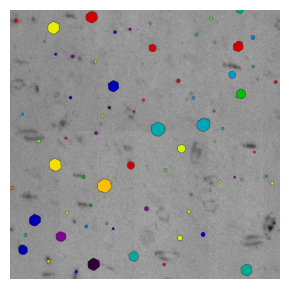

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

im1 = ax.imshow(image, cmap='gray', extent=[0, 1, 0, 1])
im2 = ax.imshow(colored_mask, alpha=1, extent=[0, 1, 0, 1])
ax.axison = False

The above shows how we can 

## Make a Video
Go through each frame and make a video [using the pre-rendered strategy shown here](https://matplotlib.org/stable/gallery/animation/dynamic_image.html#sphx-glr-gallery-animation-dynamic-image-py)

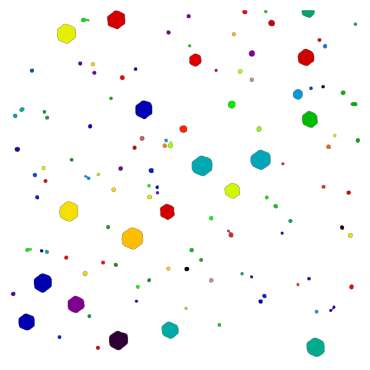

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.axison=False


#im1 = ax.imshow(image, cmap='gray', extent=[0, 1, 0, 1])
im2 = ax.imshow(colored_mask, alpha=1, extent=[0, 1, 0, 1])

def plot_frame(i):
    frame = frame_data.iloc[i]
    
    # Read the image and make the mask
    image = load_file(frame['image-path'])
    mask = load_file(frame['mask-path'])
    
    # Make a colored version of the mask
    colored_mask = mask_to_colors(mask, colors[get_global_id(i)])
        
    # Plot both
#    im1.set_data(image)
    im2.set_data(colored_mask)
    return im1, im2
    
fig.tight_layout(pad=0)

ani = animation.FuncAnimation(fig, plot_frame, frames=len(frame_data), interval=3000 / len(frame_data), blit=True)
writer = animation.FFMpegWriter(fps=15, bitrate=16000)
ani.save("movie.mp4", writer=writer, dpi=320)